In [1]:
import torch
from torchvision import transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import random
from vcs2425 import ApplyColormap, evaluate, evaluate_topk, plot_training_curves, load_dataset_splits, calculate_accuracy
import time

# 1. Reproducibility
SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

# 2. Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
COLOR_MAP = 'stacked'

# 3. Transforms
train_transform = transforms.Compose([
    transforms.Resize((342, 342), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    ApplyColormap(cmap=COLOR_MAP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((342, 342), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop((299, 299)),
    ApplyColormap(cmap=COLOR_MAP),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [3]:
# 4. Load full dataset
train_dataset, val_dataset = load_dataset_splits('../../ILSVRC2012_depth', train_transform, val_transform)

BATCH_SIZE = 256

# 7. DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=8,
    pin_memory=True,  # Better memory management
    persistent_workers=True  # Keep workers alive between iterations
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE, 
    shuffle=False,
    num_workers=8,
    pin_memory=True,  # Better memory management
    persistent_workers=True  # Keep workers alive between iterations
)

In [4]:
import tqdm
from torch.optim import Optimizer
from typing import Tuple

def train(model: nn.Module, loader: DataLoader, criterion: nn.Module, optimizer: Optimizer, device: torch.device, model_name: str = None) -> Tuple[float, float]:
    model.train()
    epoch_loss = 0.0
    epoch_accuracy = 0.0
    
    best_val_loss = float('inf')

    for images, labels in tqdm.tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        predictions = model(images)
        
        logits = predictions.logits
        aux_logits = predictions.aux_logits
        
        loss = criterion(logits, labels)
        
        if aux_logits is not None:
            aux_loss = criterion(aux_logits, labels)
            loss += 0.4 * aux_loss
        
        loss.backward()
        optimizer.step()
        acc = calculate_accuracy(logits, labels)
        
        if model_name is not None and loss.item() < best_val_loss:
            best_val_loss = loss.item()
            torch.save(model.state_dict(), f"{model_name}.pth")

        epoch_loss += loss.item()
        epoch_accuracy += acc.item()

    train_accuracy = epoch_accuracy / len(loader)
    train_loss = epoch_loss / len(loader)
    
    return train_loss, train_accuracy

# Training


We are going to train only the classifier

In [5]:
model = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last convolutional block
for param in model.Mixed_7c.parameters():  # last inception block
    param.requires_grad = True

# Unfreeze the final fully connected layer
for param in model.fc.parameters():
    param.requires_grad = True

# Optional: Also unfreeze the auxiliary classifier
for param in model.AuxLogits.parameters():
    param.requires_grad = True

model.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [6]:
# Print the number of trainable and frozen parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = total_params - trainable_params

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {frozen_params:,}")

Total parameters: 27,161,264
Trainable parameters: 11,452,496
Frozen parameters: 15,708,768


# Fine Tuning Classifier


In [7]:
LEARNING_RATE = 5e-5
WEIGHT_DECAY = 1e-4
REDUCE_LR_PATIENCE = 3
REDUCE_LR_FACTOR = 0.5

# 9. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=REDUCE_LR_FACTOR, patience=REDUCE_LR_PATIENCE)

In [8]:
NUM_EPOCHS = 30
MODEL_NAME = 'inceptionv3_pft'

train_losses = []
train_accuracies = []
eval_losses = []
eval_accuracies = []


for epoch in range(NUM_EPOCHS):
    start_time = time.time()

    train_loss, train_accuracy = train(model, 
        loader=train_loader, 
        criterion=criterion, 
        optimizer=optimizer,
        device=device,
        model_name=MODEL_NAME)

    train_time = time.time()

    eval_loss, eval_accuracy = evaluate(model, 
                                        loader=val_loader, 
                                        device=device,
                                        criterion=criterion)
    
    scheduler.step(eval_loss)
    
    eval_time = time.time()
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} Time: {(eval_time-start_time):.2f}s - \n"
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Took {(train_time-start_time):.2f}s, \n"
          f"Val Loss: {eval_loss:.4f}, Val Accuracy: {eval_accuracy:.4f}, Took {(eval_time-train_time):.2f}s \n")

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    eval_losses.append(eval_loss)
    eval_accuracies.append(eval_accuracy)

print("Training Complete!")

Epoch 1/30 Time: 89.91s - 
Train Loss: 7.7778, Train Accuracy: 0.0886, Took 73.89s, 
Val Loss: 4.8667, Val Accuracy: 0.1373, Took 16.02s 



Epoch 2/30 Time: 85.21s - 
Train Loss: 6.9891, Train Accuracy: 0.1139, Took 69.40s, 
Val Loss: 4.5699, Val Accuracy: 0.1582, Took 15.81s 



Epoch 3/30 Time: 85.30s - 
Train Loss: 6.5673, Train Accuracy: 0.1376, Took 69.26s, 
Val Loss: 4.3846, Val Accuracy: 0.1757, Took 16.04s 



Epoch 4/30 Time: 85.00s - 
Train Loss: 6.2735, Train Accuracy: 0.1581, Took 69.13s, 
Val Loss: 4.2611, Val Accuracy: 0.1868, Took 15.87s 



Epoch 5/30 Time: 84.75s - 
Train Loss: 6.0319, Train Accuracy: 0.1735, Took 68.68s, 
Val Loss: 4.1739, Val Accuracy: 0.1949, Took 16.07s 



Epoch 6/30 Time: 83.62s - 
Train Loss: 5.8511, Train Accuracy: 0.1881, Took 68.89s, 
Val Loss: 4.1436, Val Accuracy: 0.1995, Took 14.73s 



Epoch 7/30 Time: 78.24s - 
Train Loss: 5.7436, Train Accuracy: 0.1984, Took 63.48s, 
Val Loss: 4.0969, Val Accuracy: 0.2044, Took 14.76s 



Epoch 8/30 Time: 78.57s - 
Train Loss: 5.6603, Train Accuracy: 0.2041, Took 63.81s, 
Val Loss: 4.0569, Val Accuracy: 0.2090, Took 14.76s 



Epoch 9/30 Time: 79.08s - 
Train Loss: 5.5666, Train Accuracy: 0.2158, Took 64.30s, 
Val Loss: 4.0385, Val Accuracy: 0.2097, Took 14.78s 



Epoch 10/30 Time: 78.15s - 
Train Loss: 5.4837, Train Accuracy: 0.2218, Took 63.39s, 
Val Loss: 4.0280, Val Accuracy: 0.2135, Took 14.76s 



Epoch 11/30 Time: 78.00s - 
Train Loss: 5.4580, Train Accuracy: 0.2250, Took 63.24s, 
Val Loss: 4.0202, Val Accuracy: 0.2135, Took 14.76s 



Epoch 12/30 Time: 78.53s - 
Train Loss: 5.4145, Train Accuracy: 0.2307, Took 63.77s, 
Val Loss: 4.0055, Val Accuracy: 0.2144, Took 14.77s 



Epoch 13/30 Time: 79.51s - 
Train Loss: 5.3853, Train Accuracy: 0.2317, Took 64.74s, 
Val Loss: 3.9868, Val Accuracy: 0.2180, Took 14.77s 



Epoch 14/30 Time: 78.45s - 
Train Loss: 5.3454, Train Accuracy: 0.2359, Took 63.69s, 
Val Loss: 3.9822, Val Accuracy: 0.2158, Took 14.76s 



Epoch 15/30 Time: 78.00s - 
Train Loss: 5.3141, Train Accuracy: 0.2410, Took 63.22s, 
Val Loss: 3.9826, Val Accuracy: 0.2176, Took 14.78s 



Epoch 16/30 Time: 77.91s - 
Train Loss: 5.3101, Train Accuracy: 0.2389, Took 63.14s, 
Val Loss: 3.9722, Val Accuracy: 0.2187, Took 14.77s 



Epoch 17/30 Time: 78.32s - 
Train Loss: 5.2790, Train Accuracy: 0.2399, Took 63.55s, 
Val Loss: 3.9684, Val Accuracy: 0.2195, Took 14.77s 



Epoch 18/30 Time: 77.98s - 
Train Loss: 5.2746, Train Accuracy: 0.2409, Took 63.22s, 
Val Loss: 3.9612, Val Accuracy: 0.2205, Took 14.77s 



Epoch 19/30 Time: 79.33s - 
Train Loss: 5.2485, Train Accuracy: 0.2435, Took 64.57s, 
Val Loss: 3.9478, Val Accuracy: 0.2215, Took 14.76s 



Epoch 20/30 Time: 77.93s - 
Train Loss: 5.2589, Train Accuracy: 0.2439, Took 63.16s, 
Val Loss: 3.9628, Val Accuracy: 0.2203, Took 14.77s 



Epoch 21/30 Time: 77.54s - 
Train Loss: 5.2394, Train Accuracy: 0.2446, Took 62.75s, 
Val Loss: 3.9602, Val Accuracy: 0.2214, Took 14.79s 



Epoch 22/30 Time: 77.88s - 
Train Loss: 5.2250, Train Accuracy: 0.2491, Took 63.11s, 
Val Loss: 3.9622, Val Accuracy: 0.2215, Took 14.77s 



Epoch 23/30 Time: 78.06s - 
Train Loss: 5.2306, Train Accuracy: 0.2448, Took 63.29s, 
Val Loss: 3.9665, Val Accuracy: 0.2197, Took 14.77s 



Epoch 24/30 Time: 78.25s - 
Train Loss: 5.2438, Train Accuracy: 0.2437, Took 63.47s, 
Val Loss: 3.9529, Val Accuracy: 0.2210, Took 14.78s 



Epoch 25/30 Time: 77.14s - 
Train Loss: 5.2246, Train Accuracy: 0.2487, Took 62.37s, 
Val Loss: 3.9570, Val Accuracy: 0.2188, Took 14.77s 



Epoch 26/30 Time: 78.31s - 
Train Loss: 5.2041, Train Accuracy: 0.2471, Took 63.53s, 
Val Loss: 3.9413, Val Accuracy: 0.2221, Took 14.78s 



Epoch 27/30 Time: 77.67s - 
Train Loss: 5.2088, Train Accuracy: 0.2483, Took 62.90s, 
Val Loss: 3.9393, Val Accuracy: 0.2236, Took 14.77s 



Epoch 28/30 Time: 77.72s - 
Train Loss: 5.2185, Train Accuracy: 0.2468, Took 62.93s, 
Val Loss: 3.9527, Val Accuracy: 0.2238, Took 14.79s 



Epoch 29/30 Time: 78.14s - 
Train Loss: 5.2052, Train Accuracy: 0.2501, Took 63.37s, 
Val Loss: 3.9573, Val Accuracy: 0.2209, Took 14.77s 



Epoch 30/30 Time: 77.47s - 
Train Loss: 5.2109, Train Accuracy: 0.2488, Took 62.68s, 
Val Loss: 3.9459, Val Accuracy: 0.2220, Took 14.79s 

Training Complete!


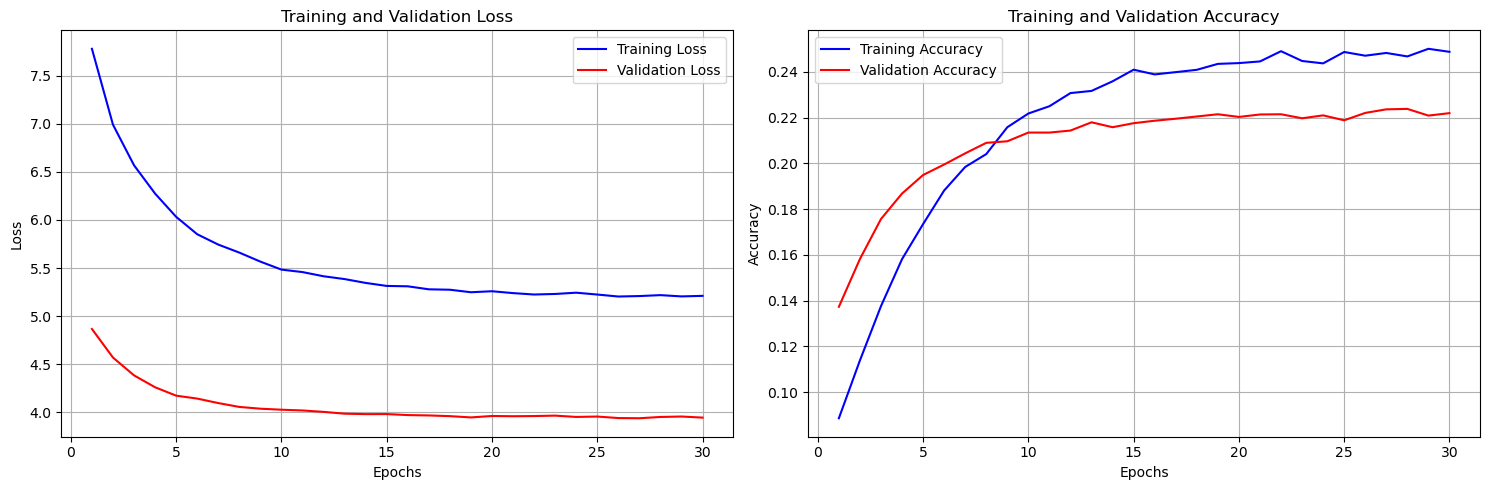

In [9]:
plot_training_curves(
    (train_losses, train_accuracies),
    (eval_losses, eval_accuracies),
)

# Evaluation metrics

In [10]:
# Load the best model weights
best_model_path = f"{MODEL_NAME}.pth"

# Load the saved model weights
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set the model to evaluation mode
print(f"Loaded best model from {best_model_path}")

# Evaluate the loaded model
val_loss, val_accuracy = evaluate(model, val_loader, criterion, device=device)
print(f"Best model - Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

Loaded best model from inceptionv3_pft.pth


Best model - Validation Loss: 3.9465, Validation Accuracy: 0.2237


In [11]:
top_1 = evaluate_topk(model, val_loader, k=1, device=device)
top_5 = evaluate_topk(model, val_loader, k=5, device=device)

print(f"Colormap: {COLOR_MAP}, Top-1 Accuracy: {top_1:.4f}, Top-5 Accuracy: {top_5:.4f}")

Colormap: stacked, Top-1 Accuracy: 0.2231, Top-5 Accuracy: 0.4457
